In [24]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import cv2
import re
import pytesseract
pytesseract.pytesseract.tesseract_cmd = r'D:\Program Files\Tesseract-OCR\tesseract.exe'

In [2]:
# Opening an Image
image_file = "1.jpg"
img = cv2.imread(image_file)

# img = cv2.imread('21EPTCS090.png')
# cv2.imshow('sample image',img)
# cv2.waitKey(0)
# cv2.destroyAllWindows()


In [3]:
## Displaying the Image Function
#https://stackoverflow.com/questions/28816046/
#displaying-different-images-with-actual-size-in-matplotlib-subplot
def display(im_path):
    dpi = 80
    im_data = plt.imread(im_path)

    height, width  = im_data.shape[:2]
    
    # What size does the figure need to be in inches to fit the image?
    figsize = width / float(dpi), height / float(dpi)

    # Create a figure of the right size with one axes that takes up the full figure
    fig = plt.figure(figsize=figsize)
    ax = fig.add_axes([0, 0, 1, 1])

    # Hide spines, ticks, etc.
    ax.axis('off')

    # Display the image.
    ax.imshow(im_data, cmap='gray')

    plt.show()

In [4]:
# Binarization
def grayscale(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

In [5]:
# Thresholding
def thresholding(image):
    return cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
    # return cv2.threshold(image, 150, 255, cv2.THRESH_BINARY)[1]

# thresh, im_bw = cv2.threshold(gray_image, 127, 255, cv2.THRESH_BINARY)


In [6]:
# Noise Removal
def noise_removal(image):
    kernel = np.ones((1, 1), np.uint8)
    image = cv2.dilate(image, kernel, iterations=1)
    kernel = np.ones((1, 1), np.uint8)
    image = cv2.erode(image, kernel, iterations=1)
    image = cv2.morphologyEx(image, cv2.MORPH_CLOSE, kernel)
    image = cv2.medianBlur(image, 3)
    return (image)

In [7]:
# Dilation and Erosion
def thin_font(image):
    image = cv2.bitwise_not(image)
    kernel = np.ones((2,2),np.uint8)
    image = cv2.erode(image, kernel, iterations=1)
    image = cv2.bitwise_not(image)
    return (image)

def thick_font(image):
    image = cv2.bitwise_not(image)
    kernel = np.ones((2,2),np.uint8)
    image = cv2.dilate(image, kernel, iterations=1)
    image = cv2.bitwise_not(image)
    return (image)

In [8]:
# Rotation / Deskewing
def getSkewAngle(cvImage) -> float:
    # Prep image, copy, convert to gray scale, blur, and threshold
    newImage = cvImage.copy()
    gray = cv2.cvtColor(newImage, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (9, 9), 0)
    thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

    # Apply dilate to merge text into meaningful lines/paragraphs.
    # Use larger kernel on X axis to merge characters into single line, cancelling out any spaces.
    # But use smaller kernel on Y axis to separate between different blocks of text
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (30, 5))
    dilate = cv2.dilate(thresh, kernel, iterations=2)

    # Find all contours
    contours, hierarchy = cv2.findContours(dilate, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key = cv2.contourArea, reverse = True)
    for c in contours:
        rect = cv2.boundingRect(c)
        x,y,w,h = rect
        cv2.rectangle(newImage,(x,y),(x+w,y+h),(0,255,0),2)

    # Find largest contour and surround in min area box
    largestContour = contours[0]
    print (len(contours))
    minAreaRect = cv2.minAreaRect(largestContour)
    cv2.imwrite("temp/boxes.jpg", newImage)
    # Determine the angle. Convert it to the value that was originally used to obtain skewed image
    angle = minAreaRect[-1]
    if angle < -45:
        angle = 90 + angle
    return -1.0 * angle


# Rotate the image around its center
def rotateImage(cvImage, angle: float):
    newImage = cvImage.copy()
    (h, w) = newImage.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    newImage = cv2.warpAffine(newImage, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
    return newImage

In [9]:
# Deskew image
def deskew(cvImage):
    angle = getSkewAngle(cvImage)
    return rotateImage(cvImage, -1.0 * angle)

In [10]:
# Removing Borders
def remove_borders(image):
    contours, heiarchy = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cntsSorted = sorted(contours, key=lambda x:cv2.contourArea(x))
    cnt = cntsSorted[-1]
    x, y, w, h = cv2.boundingRect(cnt)
    crop = image[y:y+h, x:x+w]
    return (crop)

In [11]:
# Missing Borders
def missing_borders(image):
    color = [255, 255, 255]
    top, bottom, left, right = [150]*4
    image_with_border = cv2.copyMakeBorder(no_borders, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color)
    return image_with_border

In [14]:
# display(image_file)
# display("temp/inverted.jpg")

inverted_image = cv2.bitwise_not(img)
# cv2.imwrite("temp/inverted.jpg", inverted_image)

# fixed = deskew(inverted_image)
# cv2.imwrite("temp/rotated_fixed.jpg", fixed)

gray_image = grayscale(inverted_image)
# cv2.imwrite("temp/gray.jpg", gray_image)

threshold_image = thresholding(gray_image)
# thresh, im_bw = cv2.threshold(gray_image, 127, 255, cv2.THRESH_BINARY)
# cv2.imwrite("temp/bw_image.jpg", threshold_image)

no_noise = noise_removal(threshold_image)
# cv2.imwrite("temp/no_noise.jpg", no_noise

eroded_image = thin_font(no_noise)
# cv2.imwrite("temp/eroded_image.jpg", eroded_image)

dilated_image = thick_font(eroded_image)
# cv2.imwrite("temp/dilated_image.jpg", dilated_image)

no_borders = remove_borders(dilated_image)
# cv2.imwrite("temp/no_borders.jpg", no_borders)

image_with_border = missing_borders(no_borders)
# cv2.imwrite("temp/image_with_border.jpg", image_with_border)

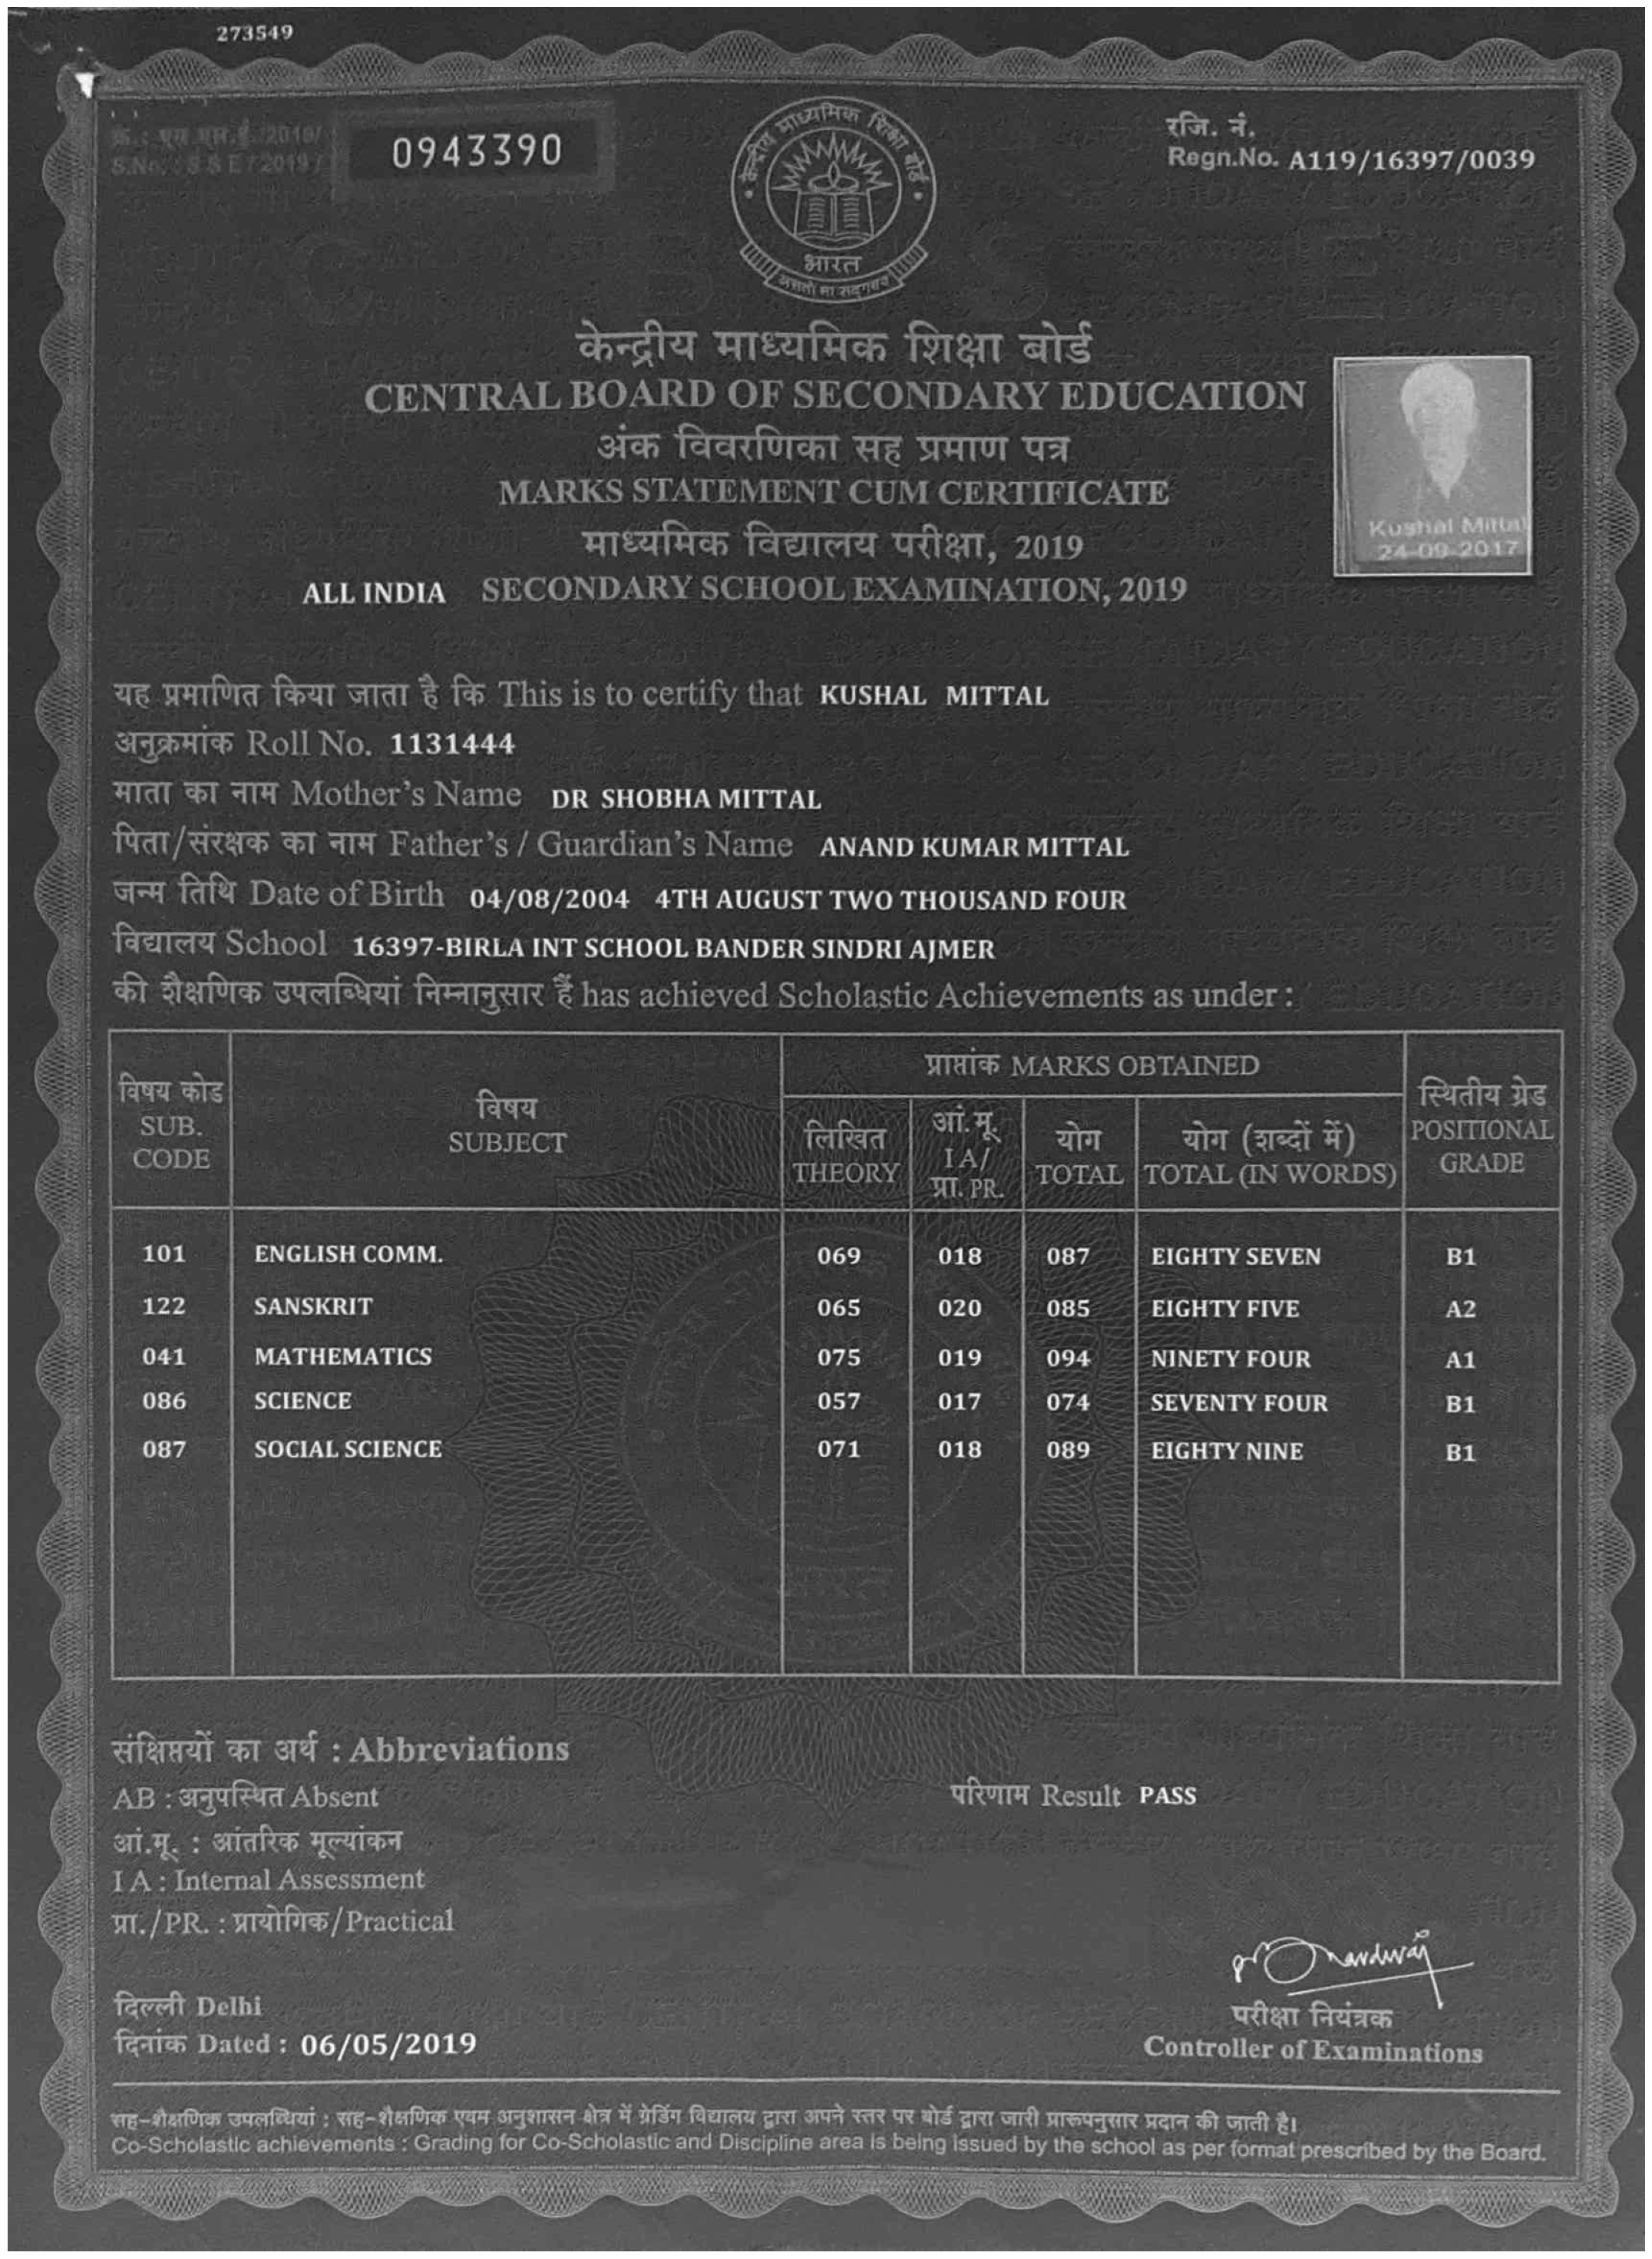

In [23]:
cv2.imwrite("temp/image_with_border.jpg", gray_image)
display("temp/image_with_border.jpg")

In [19]:
def ocr_core(img):
    text = pytesseract.image_to_string(img)
    return text

In [22]:
print(ocr_core(inverted_image))

273549

aseceranss) 0943390

CENTRAL BOARD OF SECONDARY EDUCATION
sie ferarftrat ae wart aa
MARKS STATEMENT CUM CERTIFICATE

meats ferarera ata, 2019

ALLINDIA SECONDARY SCHOOL EXAMINATION, 2019

| Ge warttra feat stat @ f& This is to certify that KUSHAL MITTAL

| PATH Roll No. 1131444
~ ¥lat St ATT Mother’s Name pR SHOBHA MITTAL
| fat/aeee ct ATH Father’s / Guardian’s Name ANAND KUMAR MITTAL
' wet fal Date of Birth 04/08/2004 4TH AUGUST TWO THOUSAND FOUR
_ faery School 16397-BIRLA INT SCHOOL BANDER SINDRI AJMER

| St Marre sreerai Hreaganr € has achieved Scholastic Achievements as under:
WHI MARKS OBTAINED
a
1A/
UPR.

ENGLISH COMM. EIGHTY SEVEN
SANSKRIT SS F EIGHTY FIVE

MATHEMATICS _| NINETY FOUR
SCIENCE : __ | SEVENTY FOUR
SOCIALSCIENCES __ | EIGHTY NINE

